In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score
)
import datetime as dt
import seaborn as sns

In [4]:
try:
    from IPython.display import display
except ImportError:
    def display(obj):
        print(obj)

### Data preparation


#### Target dataset

In [5]:
#Leemos el csv pero indicamos que el encoding es en latin para que no de error eñ simbolo 'º'
df = pd.read_csv(
    r"data/demanda-maxima-de-mendoza-2022.csv",
    encoding = "latin1",
    delimiter = ';',
    decimal = ',')

In [6]:
#Comprobamos los datos de partida:
df.head()

,DIA,HORA,TEMPERATURA °C,POTENCIA MW 2022
0,01/01/2022,22:00,32.6,758
1,02/01/2022,23:30,38.0,829
2,03/01/2022,17:30,37.1,1010
3,04/01/2022,17:00,34.2,994
4,05/01/2022,17:00,34.5,970


In [7]:
#Modificamos el nombre de las columnas
columns = ['day', 'hour', 'temperature', 'mw']
df.columns = columns

In [8]:
df.head()

,day,hour,temperature,mw
0,01/01/2022,22:00,32.6,758
1,02/01/2022,23:30,38.0,829
2,03/01/2022,17:30,37.1,1010
3,04/01/2022,17:00,34.2,994
4,05/01/2022,17:00,34.5,970


In [9]:
#Echamos un primer vistazo a la información del dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          90 non-null     object 
 1   hour         90 non-null     object 
 2   temperature  90 non-null     float64
 3   mw           90 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.9+ KB


#### Primeras conclusiones: Tenemos un dataset con 90 valores no nulos en cada atributo (es síntoma de fiabilidad ya que no va a ser necesario practicar técnicas de relleno de huecos). Los tipos de `DAY` y de `HOUR` se están leyendo como `object` aunque a priori podríamos pensar que deberían ser `datetime`. `TEMPERATURE` y `MW` son valores numéricos.

In [10]:
#Creamos una nueva columna que tenga el dia de la semana y otra columna que tenga el minuto del día
#Primero convertimos el día a formato datetime y usamos la funcion weekday 
#Como queremos obtener el minuto del día, habrá que hacer una operación con la hora del día (multiplicarla por 60). Hay que convertir también la hora a un valor numérico.

df['day'] = pd.to_datetime(df['day'], dayfirst= True)
df['weekday'] = df['day'].dt.weekday
df['hour'] = df['hour'].str.slice(0,-3).astype(int)
df['minute'] = df['hour']*60

In [11]:
#Comprobamos como ha quedado el dataset tras las modifaciones
df.head()

,day,hour,temperature,mw,weekday,minute
0,2022-01-01,22,32.6,758,5,1320
1,2022-01-02,23,38.0,829,6,1380
2,2022-01-03,17,37.1,1010,0,1020
3,2022-01-04,17,34.2,994,1,1020
4,2022-01-05,17,34.5,970,2,1020


In [12]:
#Hacemos una copia del dataset original y nos creamos un nuevo dataset modificado tal como se nos indica en el ejercicio.
data = df.copy()
data = data[['weekday','minute','temperature','mw']]

In [13]:
data.head()

,weekday,minute,temperature,mw
0,5,1320,32.6,758
1,6,1380,38.0,829
2,0,1020,37.1,1010
3,1,1020,34.2,994
4,2,1020,34.5,970


In [14]:
#Guardamos este archivo como texto plano en ".\results"
data.to_csv(r"results/series.txt", index = 0)

In [15]:
#Antes de seguir, vamos a analizar un poco más los datos con el método descripe
data.describe()

,weekday,minute,temperature,mw
count,90.000000,90.000000,90.000000,90.000000
mean,2.988889,1083.333333,31.182222,837.966667
std,2.019536,289.691816,4.865254,114.919459
min,0.000000,60.000000,15.800000,666.000000
25%,1.000000,975.000000,28.625000,763.250000
50%,3.000000,1200.000000,31.900000,811.500000
75%,5.000000,1260.000000,34.825000,898.500000
max,6.000000,1380.000000,38.500000,1231.000000


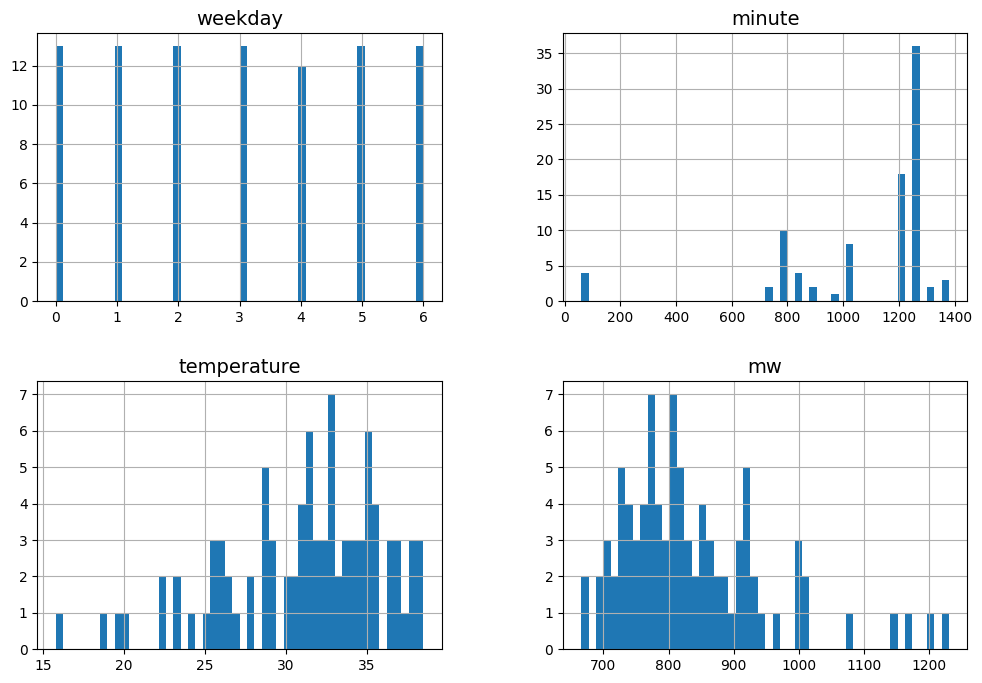

In [87]:
#Como primera aproximación a los datos, vamos a visualizar los histogramas de cada atributo

plt.rc('font', size = 14)
plt.rc('axes', labelsize = 14, titlesize = 14)
plt.rc('legend', fontsize = 14)
plt.rc('legend', fontsize = 14)
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)

data.hist(bins = 50, figsize = (12,8))

plt.show()

#### Selección de atributos y objetivo

In [17]:
#Seleccionamos la columna con el objetivo:
target_name = 'mw'
y = data[target_name]

#Los atributos:
X = data.drop([target_name], axis = 1)

#Mostramos los atributos y la variable a predecir:

In [18]:
X.head()

,weekday,minute,temperature
0,5,1320,32.6
1,6,1380,38.0
2,0,1020,37.1
3,1,1020,34.2
4,2,1020,34.5


In [19]:
y.head()

0     758
1     829
2    1010
3     994
4     970
Name: mw, dtype: int64

### Selección de sets de entrenamiento y de prueba (train-test sets)

In [20]:
#Vamos a separar nuestro set de datos en dos: uno de prueba y otro de entrenamiento, una práctica habitual en los problemas de ML
#Nos quedamos con el 80% de los datos para el entrenamiento y el 20% para el test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 49 to 51
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   weekday      72 non-null     int32  
 1   minute       72 non-null     int64  
 2   temperature  72 non-null     float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 2.0 KB
<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 40 to 28
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   weekday      18 non-null     int32  
 1   minute       18 non-null     int64  
 2   temperature  18 non-null     float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 504.0 bytes


### Vamos a visualizar ahora los datos más en detalle. Para empezar, vamos a comprobar como evoluciona el consumo en función del día de la semana

In [85]:
train_data = X_train.copy()
train_data['mw'] = y_train

In [ ]:

mean_by_weekday = (
    train_data
    .groupby('weekday')['mw']
    .mean()
)

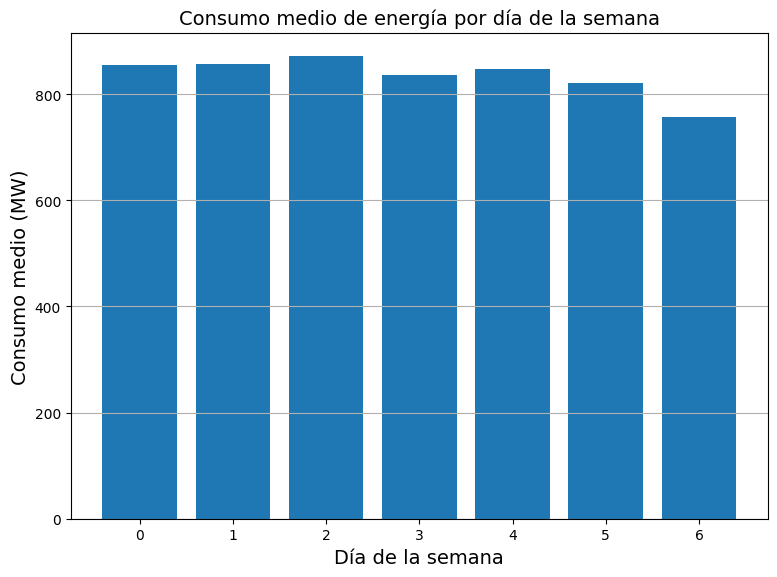

In [23]:
plt.figure(figsize=(8, 6))
plt.bar(mean_by_weekday.index, mean_by_weekday.values)

plt.title('Consumo medio de energía por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Consumo medio (MW)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

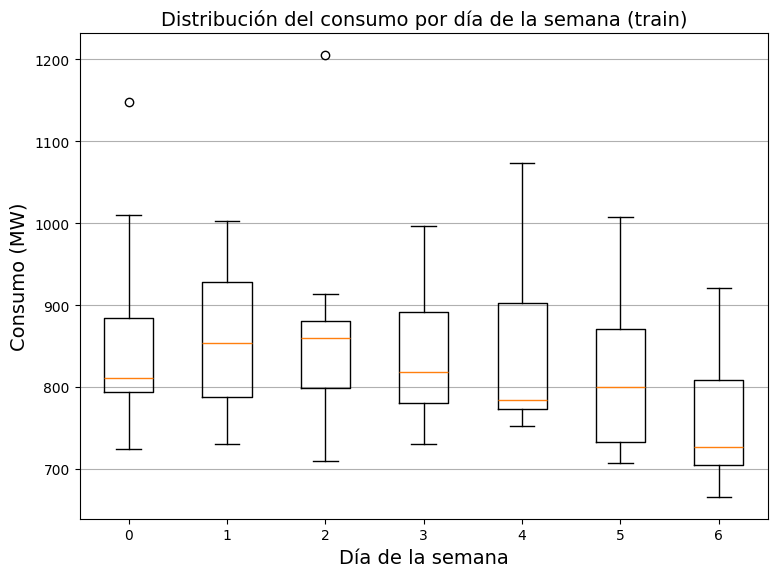

In [24]:
data_by_weekday = [
    train_data[train_data['weekday'] == day]['mw']
    for day in sorted(train_data['weekday'].unique())
]

plt.figure(figsize=(8, 6))
plt.boxplot(data_by_weekday)

plt.title('Distribución del consumo por día de la semana (train)')
plt.xlabel('Día de la semana')
plt.ylabel('Consumo (MW)')
plt.xticks(
    ticks=range(1, len(data_by_weekday) + 1),
    labels=sorted(train_data['weekday'].unique())
)

plt.grid(axis='y')
plt.tight_layout()
plt.show()

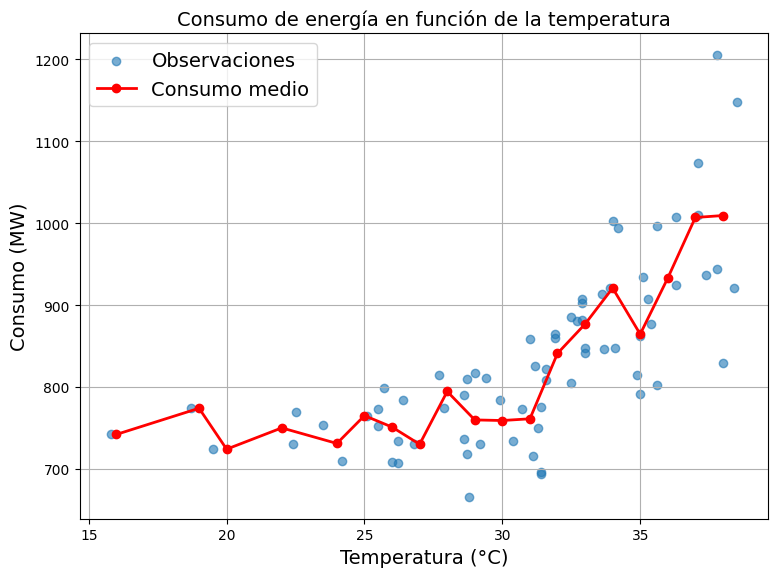

In [25]:
plt.figure(figsize=(8, 6))

# Scatter
plt.scatter(
    train_data['temperature'],
    train_data['mw'],
    alpha=0.6,
    label='Observaciones'
)

# Tendencia media
mean_by_temp = (
    train_data
    .assign(temp_round=train_data['temperature'].round())
    .groupby('temp_round')['mw']
    .mean()
)

plt.plot(
    mean_by_temp.index,
    mean_by_temp.values,
    color='red',
    marker='o',
    linewidth=2,
    label='Consumo medio'
)

plt.title('Consumo de energía en función de la temperatura')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Consumo (MW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
corr_matrix = train_data.corr()
corr_matrix['mw']

weekday       -0.282392
minute        -0.305967
temperature    0.695441
mw             1.000000
Name: mw, dtype: float64

#### Entrenamiento
Vamos a entrenar tres modelos diferentes y a compararlos entre sí. Primero vamos a entrenar un modelo de Regresión lineal para ver cómo de bien predice. Luego, tal como pide el ejercicio, haremos lo propio con un Árbol de Decisión y finalmente vamos a ver si un modelo ensemble como Random Forest mejora o no la predicción.

In [52]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [53]:
dt_model = DecisionTreeRegressor(max_depth=5, min_samples_leaf = 5, random_state = 42)
dt_model.fit(X_train, y_train)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf

In [54]:
rf_model = RandomForestRegressor(n_estimators=300, max_depth=8, min_samples_leaf=5, random_state=42)
rf_model.fit(X_train,y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

### Evaluación

Vamos a realizar una evaluación primero sobre el train set antes de pasarnos al test set para tratar de tener una idea de cómo funciona el modelo. Sin embargo, si hacemos la validación dircetamente sobre el dataset de entrenamiento, la métrica resultante será probablemente alta porque estaría prediciendo sobre los valores que se han utilizado para entrenarlo y por tanto el algoritmo los habrá "memorizado". Por ese motivo usamos la Validación Cruzada.

##### Regresión Lineal

In [76]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_model, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
dt_scores = cross_val_score(dt_model, X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
dt_rmse_scores = np.sqrt(-dt_scores)
rf_scores = cross_val_score(rf_model, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
rf_rmse_scores = np.sqrt(-rf_scores)

In [77]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [78]:
display_scores(lin_rmse_scores)

Scores: [87.54643807 57.82173125 54.81406849 92.62401268 39.64917837]
Mean: 66.4910857689517
Standard deviation: 20.289190041601426


In [79]:
display_scores(dt_rmse_scores)

Scores: [80.2310921  58.6470312  53.18403773 46.19943745 81.7732235 ]
Mean: 64.00696439766595
Standard deviation: 14.434922401392006


In [80]:
display_scores(rf_rmse_scores)

Scores: [92.82486332 53.8376407  39.21173908 53.17929952 65.48248218]
Mean: 60.90720495962383
Standard deviation: 18.000347649438


### Evaluamos los resultados en la test set

In [81]:
y_test_pred = dt_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("Model Evaluation")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Testing R2: {test_r2:.2f}")

Model Evaluation
Testing RMSE: 72.21
Testing R2: 0.74


### Visualizamos los resultados

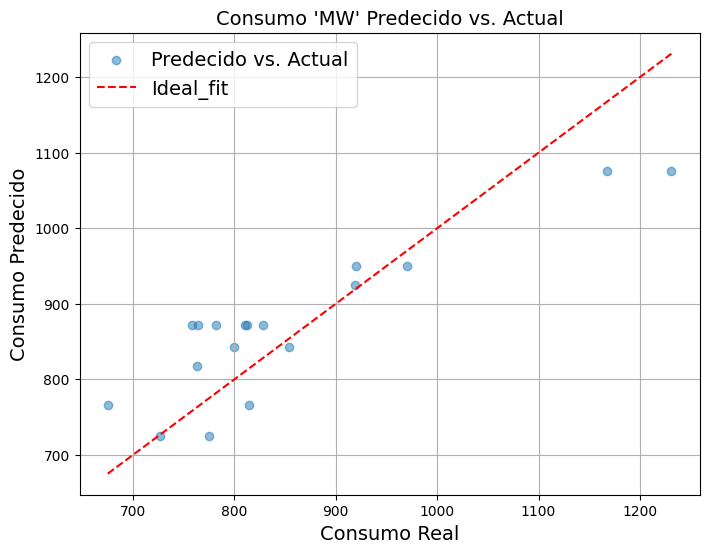

In [83]:
plt.figure(figsize = (8,6))
plt.scatter(y_test, y_test_pred, alpha = 0.5, label = "Predecido vs. Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(),y_test.max()], 'r--', label = 'Ideal_fit')
plt.xlabel('Consumo Real')
plt.ylabel('Consumo Predecido')
plt.title("Consumo 'MW' Predecido vs. Actual")
plt.legend()
plt.grid(True)
plt.show()

### Visualizamos el árbol de desición

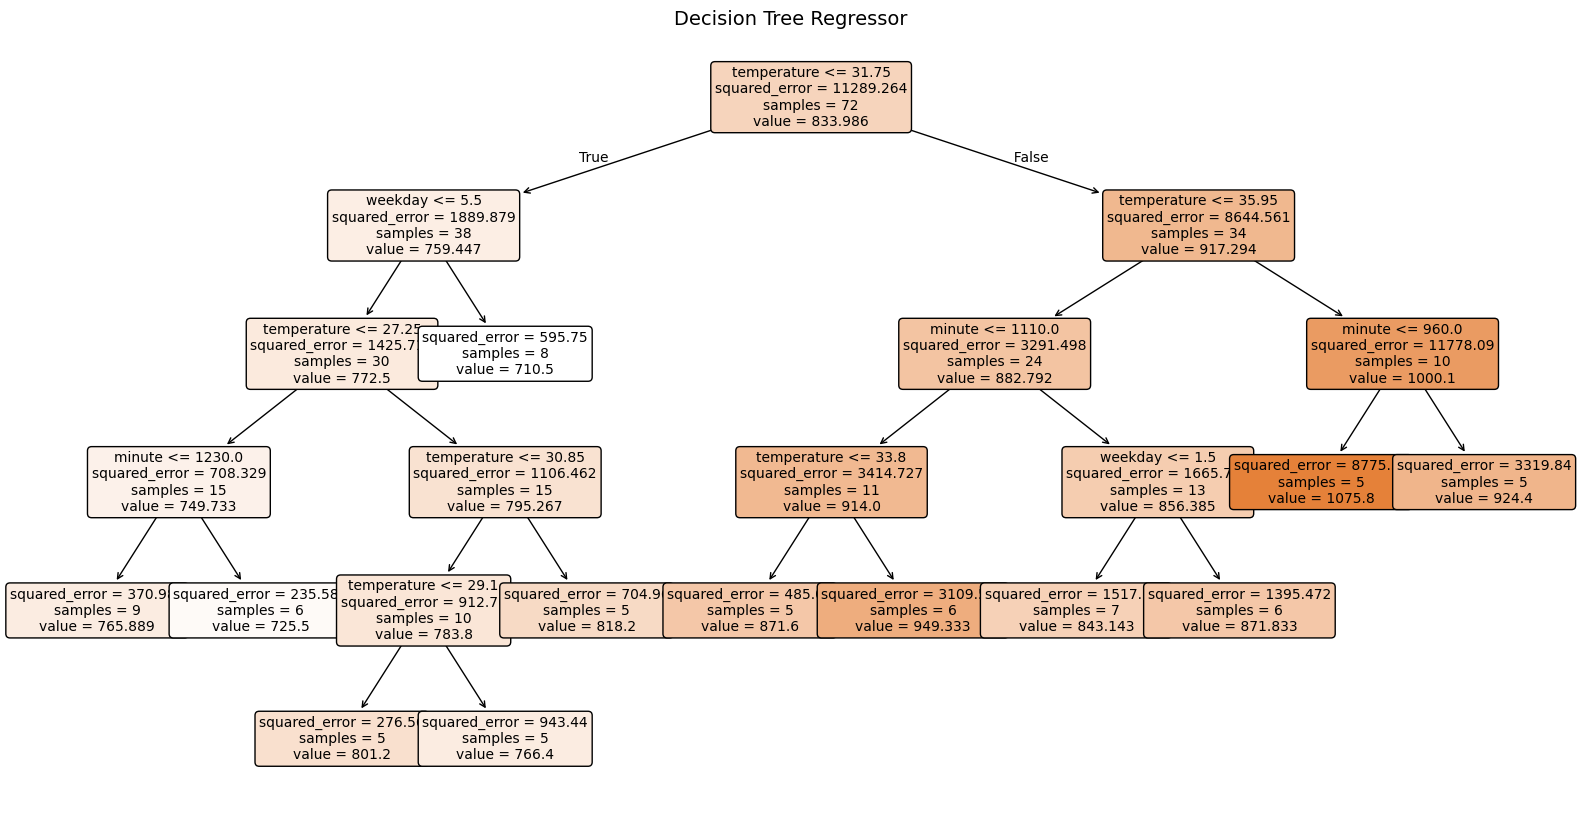

In [84]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X_train.columns,  # si X_train es DataFrame
    filled=True,
    rounded=True,
    fontsize=10
)

plt.title("Decision Tree Regressor")
plt.show()